# Implementation of deep NN using numpy

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparing the model dataset

### Import the Titanic dataset (from Kaggle)

In [2]:
df = pd.read_csv('train.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

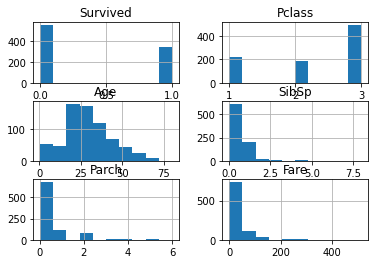

In [8]:
df.hist(column=['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'])

<AxesSubplot:>

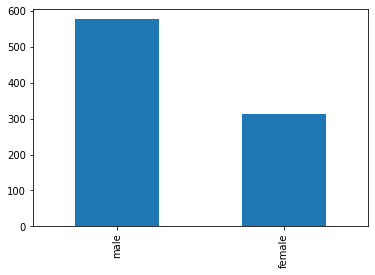

In [10]:
df['Sex'].value_counts().plot(kind='bar')

<AxesSubplot:>

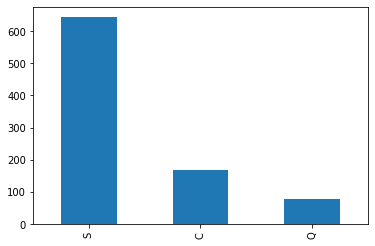

In [11]:
df['Embarked'].value_counts().plot(kind='bar')

### One-hot encode columns of categorical values

In [12]:
df_sex = pd.get_dummies(df['Sex'], prefix='Sex')
df_sex.head()

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [13]:
df_embarked = pd.get_dummies(df['Embarked'], prefix='Embarked')
df_embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


### Create numpy arrays to store both input data and y